In [3]:
%load_ext autoreload
%autoreload 2
%connect_info
%pprint 1
# General imports
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from typing import NamedTuple, List,Tuple
from dataclasses import dataclass
from gt.solutions.br import BrownRobinsonOptimizer
from IPython.display import display

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.WARNING, datefmt='%I:%M:%S')
logger = logging.getLogger(__name__)

{
  "shell_port": 52115,
  "iopub_port": 52116,
  "stdin_port": 52117,
  "control_port": 52118,
  "hb_port": 52119,
  "ip": "127.0.0.1",
  "key": "607d1569-df74510c1ad0ac603f3968ef",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-ba0ace1f-2275-4158-b790-a89a72075d61.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
Pretty printing has been turned OFF


In [2]:
original_payoff_matrix = np.array([
    [19, 6, 8, 2, 7],
    [7, 9, 2, 0, 12],
    [3, 18, 11, 9, 10],
    [19, 10, 6, 19, 4],
])
test_payoff_matrix = np.array([
    [5, 8, 7, 5, 4],
    [1, 10, 5, 5, 6],
    [2, 4, 3, 6, 2],
    [3, 5, 4, 12, 3],
])
start_payoff_matrix = original_payoff_matrix

In [3]:
def to_df(matrix: np.ndarray) -> pd.DataFrame:
    return pd.DataFrame(data=matrix,
                        index=[f'a{i+1}' for i in range(matrix.shape[0])],
                        columns=[f'b{i+1}' for i in range(matrix.shape[1])])
    
payoff_matrix = to_df(start_payoff_matrix)
payoff_matrix

,b1,b2,b3,b4,b5
a1,19,6,8,2,7
a2,7,9,2,0,12
a3,3,18,11,9,10
a4,19,10,6,19,4


In [4]:
def create_risk_table(matrix):
    matrix = matrix.copy()
    max_reward = matrix.max(axis=0)
    logger.debug(f"Max rewards for risk table:\n{max_reward}")
    for column in matrix.columns:
        matrix[column] = max_reward[column] - matrix[column]
    return matrix

print("RISK TABLE")
create_risk_table(payoff_matrix)

05:00:26 DEBUG:Max rewards for risk table:
b1    19
b2    18
b3    11
b4    19
b5    12
dtype: int32


RISK TABLE


,b1,b2,b3,b4,b5
a1,0,12,3,17,5
a2,12,9,9,19,0
a3,16,0,0,10,2
a4,0,8,5,0,8


In [282]:
def criteria(matrix: pd.DataFrame, hurwitz_alpha: float=0.5):
    criteria_matrix = pd.DataFrame(index=[f'a{i+1}' for i in range(matrix.shape[0])])
    criteria_matrix['criteria_bernoulli'] = matrix.mean(axis=1)
    criteria_matrix['criteria_wald'] = matrix.min(axis=1)
    criteria_matrix['criteria_optimistic'] = matrix.max(axis=1)
    criteria_matrix['criteria_hurwitz'] = hurwitz_alpha * criteria_matrix['criteria_wald'] + (1-hurwitz_alpha) * criteria_matrix['criteria_optimistic']
    # make a risk table for Savage criteria
    risk_table = create_risk_table(matrix)
    logger.info("PLEASE NOTE THAT SAVAGE CRITERIA IS NEGATED SO THAT max() could work next "
                "instead of min (as correct formulae here suggests: "
                "https://en.wikipedia.org/wiki/Regret_(decision_theory))")
    criteria_matrix['criteria_savage'] = -risk_table.max(axis=1)
    
    # count advisory score - number of times the strategy a_i is best in terms of criteria
    scores = np.zeros(len(matrix))
    criteria = [column for column in criteria_matrix.columns if column.startswith('criteria_')]
    for cri in criteria:
        logger.debug(f"Looking at criteria: {cri}")
        best_cri_value = criteria_matrix[cri].max()
        for i in range(len(criteria_matrix)):
            if criteria_matrix.iloc[i][cri] == best_cri_value:
                logger.info(f"Column {i} gets one point as its '{cri}' has best value of {best_cri_value}")
                scores[i] += 1
                
    criteria_matrix['scores_best'] = scores 
    return pd.concat([matrix, criteria_matrix], axis=1)
    
payoff_criteria_matrix = criteria(payoff_matrix)
print("CRITERIA MATRIX")
payoff_criteria_matrix

NameError: name 'payoff_matrix' is not defined

In [6]:
def create_sphere(radius: float=1.0, dots: int=50):
    return (radius, *np.mgrid[0.0:np.pi:dots*1j, 0.0:2.0*np.pi:dots*1j])

def create_plot(figsize=(5, 5)):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    plt.tight_layout()
    return plt, ax

def scale_plot(ax, 
               x_min: float=-1, x_max: float=1, 
               y_min: float=-1, y_max: float=1, 
               z_min: float=-1, z_max: float=1):
    # Create cubic bounding box to simulate equal aspect ratio
    ranges = np.array([x_max - x_min, y_max - y_min, z_max - z_min])
    max_range = ranges.max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x_max+x_min)
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y_max+y_min)
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z_max+z_min)
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'r', linewidth=50)

In [10]:
### INFINITE SEARCH
#Set colours and render
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import DistanceMetric
from concurrent.futures import ProcessPoolExecutor


class SpherePursuitSolver:

    def __init__(self, epsilon_radius: float, radius: float = 1, search_dots: int = 1):
        self.radius = radius
        self.epsilon = np.clip(epsilon_radius, a_min=0, a_max=radius)
        self.search_dots = search_dots

    def solve_analytical(self):
        print("The best strategy for the pursuiter is to randomly select dots on a sphere"
              "such that all dots, forming a surface with radius 'epsilon', do not overlap: "
              "each point is away from another from 2*epsilon_radius")
        print("The best strategy for a person being pursuited is to select a random dot on a sphere")
        # Game value
        # Here it is a sum of all surface area for all points
        # Surface value for a sphere slice is: 2*Pi*h*R
        # h = R*(1 - cos(epsilon_radius/R))
        # ref: Petrosyan, page 96, 2.8.3 and 2.1.2
        area, covered_surface, total_surface = self.area(self.search_dots)

        # game_value = self.search_dots / 2 * (1 - np.sqrt(1 - (self.epsilon / self.radius)**2))
        # print(game_value, area)
        game_value = min(1.0, area)
        print(f"Game cost for optimal strategies is: {game_value:.3f} "
              f"(covered: {covered_surface:.3f}, total: {total_surface:.3f})")
        return game_value

    @classmethod
    def polar_angle_to_cartesian(cls, angle, radius: float = 1.0):
        return cls.polar_to_cartesian((radius, *angle))

    @classmethod
    def polar_to_cartesian(cls, points: np.ndarray) -> np.ndarray:
        r = points[0]
        phi = points[1]
        theta = points[2]
        x = r * np.sin(phi) * np.cos(theta)
        y = r * np.sin(phi) * np.sin(theta)
        z = r * np.cos(phi)
        return np.array([x, y, z])

    @classmethod
    def arc_dist_cartesian(cls, p1: np.ndarray, p2: np.ndarray, radius: float = None):
        """
        Arc distance (Great-Circle distance)
        between two points in Cartesian space
        """
        if radius is None:
            radius = np.linalg.norm(p1, axis=1)
        c = np.linalg.norm(np.array(p1) - np.array(p2), axis=1)
        return 2 * np.arcsin(c / 2 * radius)

    @classmethod
    def arcs_from_points(cls, p1: np.ndarray, p2: np.ndarray, radius=1.0) -> np.ndarray:
        """
        NONWORKING
        Arc distance (Great-Circle distance)
        between two points in Cartesian space
        """
        lat1, lon1 = p1.transpose()
        lat2, lon2 = p2.transpose()
        lat1 = np.pi / 2 - lat1
        lat2 = np.pi / 2 - lat2
        lon1 = lon1 - np.pi
        lon2 = lon2 - np.pi

        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = (np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2)
        # a = np.sin(0.5*(p1[0]-p2[0]))**2 + np.cos(p1[0])*np.cos(p2[0])*(np.sin(0.5*(p1[1]-p2[1]))**2)
        c = 2 * np.arcsin(np.sqrt(a))
        return radius * c

    def remove_points_from_sphere(self, free_points, polar_point, threshold):
        points = []
        distances = SpherePursuitSolver.arcs_from_points(
            np.repeat([polar_point[1:]], len(free_points), axis=0),
            free_points,
            radius=self.radius
        )
        return free_points[distances >= threshold]

    #         for s_line in np.dstack(polar_sphere[1:]):
    #             #sphere_points = np.array(list(map(SpherePursuitSolver.polar_angle_to_cartesian, s_line)))
    #             #distances = SpherePursuitSolver.arc_dist_cartesian(np.repeat([point1], len(s_line), axis=0), sphere_points)
    #             distances = SpherePursuitSolver.arcs_from_points(
    #                 np.repeat([polar_point[1:]], len(s_line), axis=0),
    #                 s_line,
    #                 radius=self.radius
    #             )
    #             points.extend(
    #                 s_line[distances < self.epsilon].vstack(
    #                     np.repeat([polar_point[0]], len(s_line))
    #                 )
    #             )
    #        return points

    def random_point(self):
        return self.radius, np.random.uniform(0, np.pi), np.random.uniform(0, 2 * np.pi)

    def solve_simulation(self, num_simulations: int = 100, real: float = None, ndots: int = 20,
                         visualize_each: int = -1):
        polar_sphere = create_sphere(dots=ndots, radius=self.radius)
        wins = 0
        for step in range(num_simulations):
            if visualize_each > 0 and (step + 1) % visualize_each == 0:
                logger.warning("Visualizing game...")
                visualize = True
            else:
                visualize = False
            if step % 1000 == 0:
                value = wins / (step + 1)
                error = (
                    (100 * np.abs(value - real) / real)
                    if real is not None
                    else "N/A"
                )
                logger.warning(f"SIMULATION STEP: {step + 1} (so far: {value:.3f}. MAPE: {error:.3f}%)...")
            wins += self.solve_simulation_step(polar_sphere, visualize=visualize)
        logger.info(f"Total plays: {num_simulations}, "
                    f"wins: {wins}, game value: {wins / num_simulations}")
        return wins / num_simulations

    def plot_game(self, polar_sphere, hiding_point, pursuit_points,
                  sphere_color: str = "yellow", hiding_color: str = 'green', pursuer_color: str = 'red'):
        free_points = []
        for s_line in np.dstack(polar_sphere[1:]):
            free_points.extend(s_line)
        free_points = np.array(free_points)
        pursuit_areas = np.array([])
        for pursuit_point in pursuit_points:
            distances = self.arcs_from_points(
                np.repeat([pursuit_point[1:]], len(free_points), axis=0),
                free_points,
                radius=self.radius
            )
            area_points = free_points[distances <= self.epsilon]
            radiuses = np.repeat([self.radius], len(area_points))[np.newaxis].T
            area_points = np.append(radiuses, area_points, axis=1)
            area_points = self.polar_to_cartesian(area_points.T)
            if not len(pursuit_areas):
                pursuit_areas = area_points
            pursuit_areas = np.concatenate((pursuit_areas, area_points), axis=1)
        # print(pursuit_areas)
        fig, ax = create_plot()
        sphere = self.polar_to_cartesian(polar_sphere)
        ax.plot_surface(*sphere, rstride=1, cstride=1, color=sphere_color, alpha=0.1, linewidth=0)
        ax.scatter(*pursuit_areas, color=pursuer_color, s=5, alpha=0.3)
        ax.scatter(*self.polar_to_cartesian(hiding_point), color=hiding_color, s=100)
        ax.scatter(*self.polar_to_cartesian(pursuit_points.T), color=pursuer_color, s=50)

        scale_plot(ax)
        plt.show()

    def area(self, num_points) -> Tuple[float, float, float]:
        surface_area = 2 * np.pi * self.radius ** 2 * (1 - np.cos(self.epsilon / self.radius))
        covered_surface = num_points * surface_area
        total_surface = 4 * np.pi * self.radius ** 2
        return covered_surface / total_surface, covered_surface, total_surface

    def solve_simulation_step(self, polar_sphere, visualize: bool = False) -> int:
        free_points = []
        for s_line in np.dstack(polar_sphere[1:]):
            free_points.extend(s_line)
        free_points = np.array(free_points)
        original_free_points = free_points.copy()
        logger.info(f"Free points ({len(free_points)})")
        cartesian_sphere = self.polar_to_cartesian(polar_sphere)
        #
        random_points = np.array([])
        hiding_point = self.random_point()
        logger.info(f"Hiding player point is {hiding_point}")
        for i in range(self.search_dots):
            logger.debug(f"Generating {i}th point...")
            satisfied = False
            iterations = 0
            max_distance_point, max_distance = None, None
            lookup_index = np.random.randint(0, len(free_points)) if not len(random_points) else 0
            if len(free_points) == 0:
                logger.warn(f"No points left, so we're choosing back from all points")
                free_points = original_free_points
                for random_point in random_points:
                    free_points = self.remove_points_from_sphere(free_points, candidate, self.epsilon)
                lookup_index = 0
            if self.area(len(random_points))[0] >= 1:
                logger.warn(f"We have covered an entire area with points, we can select others randomly.")
                break
            while not satisfied:

                if lookup_index >= len(free_points):
                    logger.warning(f"We have seen all the points. We will select most applicable one.")
                    candidate = max_distance_point
                    break
                candidate = [self.radius, *free_points[lookup_index]]
                logger.debug(
                    f"Selecting {candidate} for point {i} (variants left: {len(free_points) - 1 - lookup_index})...")
                if not len(random_points):
                    logger.debug(f"Adding point as none added yet")
                    satisfied = True
                else:
                    logger.debug("Generating distances between other points...")
                    distances = self.arcs_from_points(
                        np.repeat([candidate[1:]], len(random_points), axis=0),
                        random_points[:, 1:]
                    )
                    logger.debug(f"Distances are: {distances}")
                    if ((distances >= 2 * self.epsilon).all()):
                        logger.debug(f"Point {candidate} is away from all points at least from 2*epsilon "
                                     f"- it's a candidate match!.")
                        satisfied = True
                    elif max_distance is None or max_distance < sum(distances):
                        logger.debug("Adding candidate as max distance candidate")
                        max_distance = sum(distances)
                        max_distance_point = candidate
                lookup_index += 1
                iterations += 1
            if not len(random_points):
                random_points = np.array([candidate])
            else:
                random_points = np.append(random_points, candidate).reshape(-1, 3)
            logger.info(random_points.shape)
            logger.info(f"Spent {iterations} iterations to generate {i}th point")
            logger.debug(f"Removing point {candidate} and all neighbors")
            free_points = self.remove_points_from_sphere(free_points, candidate, 2 * self.epsilon)
            logger.debug(f"Free points left: {len(free_points)}")
        logger.info(f"Selected points {len(random_points)}")
        logger.info(f"Testing to see if we're found the hiding player...")
        distances = self.arcs_from_points(
            np.repeat([hiding_point[1:]], len(random_points), axis=0),
            random_points[:, 1:]
        )
        logger.info(f"Distances from a hiding spot: {distances}")
        result = 0
        if (distances <= self.epsilon).any():
            logger.info("Game succeeded with a win!")
            result = 1
        else:
            logger.info("Game was lost by the pursuer!")
        if visualize:
            self.plot_game(polar_sphere, hiding_point, random_points)
        return result

09:42:36 WARNING:Visualizing game...
09:42:36 WARNING:SIMULATION STEP: 1 (so far: 0.000. MAPE: 100.000%)...
e:\source\personal\university\2019\gametheory\.venv\lib\site-packages\ipykernel_launcher.py:187: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
09:42:36 WARNING:No points left, so we're choosing back from all points


The best strategy for the pursuiter is to randomly select dots on a spheresuch that all dots, forming a surface with radius 'epsilon', do not overlap: each point is away from another from 2*epsilon_radius
The best strategy for a person being pursuited is to select a random dot on a sphere
Game cost for optimal strategies is: 0.919 (covered: 11.553, total: 12.566)


09:42:37 WARNING:We have seen all the points. We will select most applicable one.


<IPython.core.display.Javascript object>


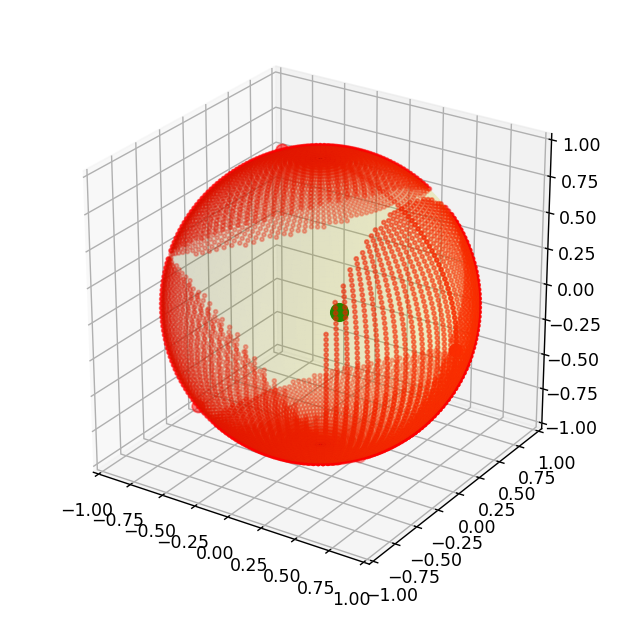

Simulation answer is: 1.0 (MAPE: 8.77%)


In [16]:
solver = SpherePursuitSolver(np.pi/3, search_dots=4)
analytical_value = solver.solve_analytical()
simulation_value = solver.solve_simulation(num_simulations=1, visualize_each=1, ndots=100, real=analytical_value)
error = np.abs(simulation_value - analytical_value) / analytical_value
print(f"Simulation answer is: {simulation_value} (MAPE: {error*100:.2f}%)")